In [219]:
import time, unicodedata, re, warnings, os, random
warnings.filterwarnings('ignore')

import numpy as np 
import pandas as pd

import pylab 
from yellowbrick.regressor import ResidualsPlot
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import style
style.use('ggplot')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# For Partial Dependence Plots
from pdpbox import pdp

#For generating Word Cloud
from wordcloud import WordCloud
from nltk.corpus import stopwords

# For Principal component analysis.
from sklearn.decomposition import PCA

# for variable transformation
import scipy.stats as stats

# to build the models
from sklearn.linear_model import LinearRegression, Lasso, LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import xgboost as xgb
import lightgbm as lgb

# to evaluate the models
from sklearn.metrics import mean_squared_error, mean_squared_log_error, \
                            r2_score, explained_variance_score, \
                            classification_report, confusion_matrix

In [220]:
# Scraped Data sets 
emlakjet_df = pd.read_csv('./data/emlakjet_data.csv')
huriyet_df = pd.read_csv('./data/huriyyet_final_df.csv')
sahibinden_df =pd.read_csv('./data/sahibinden_final.csv')
locs_for_huriyet_df = pd.read_csv('./data/locs_for_huriyyet_df.csv')

"locs_for_huriyet_df" contains districts and counties for "huriyet_df" data set. I will merge these two data sets.

In [221]:
emlakjet_df.head()

,Unnamed: 0,Banyo Sayısı,Bina Yaşı,Brüt Metrekare,Cinsi,Dairenin Katı,Depozito,Eşya Durumu,Isıtma,Kat Sayısı,...,Türü,WC Sayısı,Yapı Durumu,Yapı Tipi,İlan Numarası,İlan Tarihi,district,county,Title,price
0,0,2,4,130m,NaN,4. Kat,-,-,Klimalı,10,...,Daire,2,İkinci El,Betonarme,6961687,02.02.2019,Mahmutlar Mahallesi',Alanya,Alanya mahmutlarda deniz manzaralı kiralık 2+1...,900 TL
1,1156,2,5-10,180m,NaN,1. Kat,1300 TRY,-,Kombi Doğalgaz,9,...,Daire,3,İkinci El,Betonarme,6836698,01.02.2019,Kemerağzı Mahallesi',Aksu,Oteller bölgesinde kiralık 3+1 doğalgazlı site...,1.300 TL
2,2312,1,5-10,180m,NaN,20-30,1600 TRY,-,Kombi Doğalgaz,9,...,Daire,2,İkinci El,Betonarme,6587034,01.02.2019,Kemerağzı Mahallesi',Aksu,Mobilyalı kiralık-3+1 daire kiralık,1.600 TL
3,3468,2,3,70m,NaN,2. Kat,-,Eşyalı,Klimalı,12,...,Daire,1,İkinci El,Betonarme,6849190,02.02.2019,Mahmutlar Mahallesi',Alanya,Alanya da mahmutlar da rezidans da eşyalı kira...,1.200 TL
4,3502,2,3,70m,NaN,2. Kat,-,-,Klimalı,12,...,Daire,1,İkinci El,Betonarme,6849190,02.02.2019,Mahmutlar Mahallesi',Alanya,Alanya da mahmutlar da rezidans da eşyalı kira...,1.200 TL


In [222]:
emlakjet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1499 entries, 0 to 1498
Data columns (total 27 columns):
Unnamed: 0         1499 non-null int64
Banyo Sayısı       1499 non-null object
Bina Yaşı          1499 non-null object
Brüt Metrekare     1499 non-null object
Cinsi              0 non-null float64
Dairenin Katı      1499 non-null object
Depozito           1499 non-null object
Eşya Durumu        1499 non-null object
Isıtma             1497 non-null object
Kat Sayısı         1499 non-null int64
Kategori           1499 non-null object
Kullanım Durumu    1499 non-null object
Net Metrekare      1497 non-null object
Oda Sayısı         1499 non-null object
Salon Metrekare    1499 non-null object
Site İçerisinde    1499 non-null object
Takas              1499 non-null object
Türü               1499 non-null object
WC Sayısı          1499 non-null object
Yapı Durumu        1499 non-null object
Yapı Tipi          1499 non-null object
İlan Numarası      1499 non-null int64
İlan Tarihi       

In [223]:
huriyet_df.head()

,Unnamed: 0,Aidat,Banyo Sayısı,Bina Yaşı,Brüt Metrekare,Bulunduğu Kat,Cephe Seçenekleri,Depozito,Eşyalı,Isınma Tipi,...,Title,Unnamed: 0.1,Yakıt Tipi,Yapı Tipi,Yapının Durumu,Yetkili Ofis,id,price,Öğrenciye/Bekara,İlan Tarihi
0,0,20 TL,1.0,1.0,160 m²,1,"Güney, Batı",850 TL,Hayır,Klima,...,ANTALYA KEPEZ SÜTÇÜLER'DE 3+1 150 M2 KİRALIK D...,0,Elektrik,Betonarme,İkinci El,Yok,92837-795,850 TL,Hayır,2.02.2019
1,1,NaN,1.0,15.0,23 m²,1,NaN,NaN,Hayır,Klima,...,ANTALYA LARA'DA AYLIK ODA EKONOMİK FIRSAT,1,Elektrik,Betonarme,İkinci El,NaN,0-15868340,1.299 TL,Evet,1.01.2019
2,2,120 TL,1.0,0.0,125 m²,3,"Güney, Doğu",750 TL,Hayır,Klima,...,ANTALYA KEPEZ HAVUZLU SİTE İÇİ KİRALIK DAİRE,2,Elektrik,Betonarme,Sıfır,Yok,92837-767,750 TL,NaN,2.02.2019
3,3,NaN,2.0,0.0,90 m²,NaN,"Kuzey, Güney, Doğu, Batı",NaN,Hayır,Kombi,...,2+1 KUŞKAVAĞI MAH. KİRALIK SIFIR BAHÇE DUBLEKS,3,NaN,NaN,NaN,Yok,50997-283,1.750 TL,NaN,25.01.2019
4,4,20 TL,1.0,30.0,140 m²,3,"Kuzey, Güney, Batı",1.100 TL,Evet,Klima,...,ALANYA DAMLATAŞ'TA SİTEDE EŞYALI 2+1 KİRALIK D...,4,Elektrik,Betonarme,İkinci El,Var,88252-2273,1.100 TL,Evet,2.02.2019


In [224]:
huriyet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1022 entries, 0 to 1021
Data columns (total 30 columns):
Unnamed: 0           1022 non-null int64
Aidat                434 non-null object
Banyo Sayısı         1021 non-null float64
Bina Yaşı            1020 non-null float64
Brüt Metrekare       1021 non-null object
Bulunduğu Kat        917 non-null object
Cephe Seçenekleri    789 non-null object
Depozito             523 non-null object
Eşyalı               1018 non-null object
Isınma Tipi          1021 non-null object
Kat Sayısı           909 non-null float64
Konut Tipi           1021 non-null object
Konut Şekli          896 non-null object
Krediye Uygunluk     19 non-null object
Kullanım Durumu      829 non-null object
Net Metrekare        1021 non-null object
Oda + Salon          1021 non-null object
Site İçerisinde      306 non-null object
Takas                14 non-null object
Tapu Durumu          53 non-null object
Title                1021 non-null object
Unnamed: 0.1         10

In [225]:
locs_for_huriyet_df.head()

,Unnamed: 0,county,district,id
0,0,Kepez,Hüsnü Karakaş,92837-767
1,1,Muratpaşa,Çağlayan,0-15868340
2,2,Kepez,Sütçüler,92837-795
3,3,Muratpaşa,Kızılsaray,103168-51
4,4,Muratpaşa,Yenigün,105872-30


In [226]:
sahibinden_df.head()

,Unnamed: 0,Aidat (TL),Balkon,Banyo Sayısı,Bina Yaşı,Bulunduğu Kat,Depozito (TL),Eşyalı,Isıtma,Kat Sayısı,...,county,district,id,m² (Brüt),m² (Net),price,seller_link,seller_name,İlan No,İlan Tarihi
0,0,Belirtilmemiş,Yok,1,0,Bodrum Kat,Belirtilmemiş,Evet,Klima,3,...,Kepez,Ahatlı,656714380,45,43.0,750 TL,https://evbulemlakk.sahibinden.com/,EV BUL EMLAK,656714380,05 Şubat 2019
1,1,200,Var,1,0,3,Belirtilmemiş,Hayır,Klima,4,...,Manavgat,Manavgat,656257655,130,100.0,1250 TL,https://sunemlakgyo.sahibinden.com/,SUN EMLAK GYO,656257655,04 Şubat 2019
2,2,Belirtilmemiş,Var,1,5-10 arası,4,Belirtilmemiş,Hayır,Klima,4,...,Manavgat,Manavgat,655507149,160,130.0,850 TL,https://sunemlakgyo.sahibinden.com/,SUN EMLAK GYO,655507149,02 Şubat 2019
3,3,20,Var,2,5-10 arası,2,Belirtilmemiş,Hayır,Yok,3,...,Muratpasa,Lara,632539713,135,129.0,1600 TL,https://hakangayrimenkul.sahibinden.com/,HAKAN EMLAK GAYRİMENKUL ANTALYA,632539713,02 Şubat 2019
4,4,50,Var,1,21-25 arası,1,2.500,Hayır,Klima,5,...,Muratpasa,Lara,654673381,180,155.0,2500 TL,https://bellagayrimenkul.sahibinden.com/,Bella Gayrimenkul,654673381,01 Şubat 2019


In [227]:
sahibinden_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 825 entries, 0 to 824
Data columns (total 25 columns):
Unnamed: 0         825 non-null int64
Aidat (TL)         825 non-null object
Balkon             825 non-null object
Banyo Sayısı       825 non-null object
Bina Yaşı          825 non-null object
Bulunduğu Kat      825 non-null object
Depozito (TL)      825 non-null object
Eşyalı             825 non-null object
Isıtma             825 non-null object
Kat Sayısı         825 non-null int64
Kullanım Durumu    825 non-null object
Oda Sayısı         825 non-null object
Site İçerisinde    745 non-null object
ad_link            825 non-null object
ad_title           825 non-null object
county             825 non-null object
district           825 non-null object
id                 825 non-null int64
m² (Brüt)          825 non-null int64
m² (Net)           793 non-null float64
price              825 non-null object
seller_link        825 non-null object
seller_name        825 non-null object
İ

in the dataset that scraped from hurriyetemlak.com, we have white spaces beggining of the ids.
in order to merge this data set with data set that consists of locations for hurriyetemlak dataset,
I will remove white spaces.

In [228]:
huriyet_df.id = huriyet_df.id.astype(str).apply(lambda x: x.replace(' ', '', -1))

In [229]:
huriyet_df = pd.merge(huriyet_df, locs_for_huriyet_df, left_on='id', right_on='id')
huriyet_df

,Unnamed: 0_x,Aidat,Banyo Sayısı,Bina Yaşı,Brüt Metrekare,Bulunduğu Kat,Cephe Seçenekleri,Depozito,Eşyalı,Isınma Tipi,...,Yapı Tipi,Yapının Durumu,Yetkili Ofis,id,price,Öğrenciye/Bekara,İlan Tarihi,Unnamed: 0_y,county,district
0,0,20 TL,1.0,1.0,160 m²,1,"Güney, Batı",850 TL,Hayır,Klima,...,Betonarme,İkinci El,Yok,92837-795,850 TL,Hayır,2.02.2019,2,Kepez,Sütçüler
1,1,NaN,1.0,15.0,23 m²,1,NaN,NaN,Hayır,Klima,...,Betonarme,İkinci El,NaN,0-15868340,1.299 TL,Evet,1.01.2019,1,Muratpaşa,Çağlayan
2,2,120 TL,1.0,0.0,125 m²,3,"Güney, Doğu",750 TL,Hayır,Klima,...,Betonarme,Sıfır,Yok,92837-767,750 TL,NaN,2.02.2019,0,Kepez,Hüsnü Karakaş
3,3,NaN,2.0,0.0,90 m²,NaN,"Kuzey, Güney, Doğu, Batı",NaN,Hayır,Kombi,...,NaN,NaN,Yok,50997-283,1.750 TL,NaN,25.01.2019,594,Konyaaltı,Kuşkavağı
4,7,NaN,1.0,2.0,100 m²,1,"Kuzey, Güney, Doğu",NaN,Hayır,Klima,...,Betonarme,İkinci El,Yok,77527-3115,1.000 TL,NaN,2.02.2019,233,Muratpaşa,Kızılarık
5,12,50 TL,2.0,10.0,180 m²,4,"Kuzey, Doğu",1.500 TL,Hayır,Klima,...,Betonarme,İkinci El,Yok,98706-218,1.500 TL,Evet,2.02.2019,186,Alanya,Cumhuriyet
6,13,NaN,1.0,0.0,60 m²,Yüksek Giriş,"Güney, Doğu",600 TL,Hayır,Klima,...,Betonarme,Sıfır,Var,99691-732,600 TL,Evet,3.02.2019,156,Kepez,Ahatlı
7,16,40 TL,1.0,10.0,90 m²,1,Güney,750 TL,Hayır,Klima,...,Betonarme,İkinci El,Var,10655-1820,750 TL,Evet,2.02.2019,36,Muratpaşa,Tahılpazarı
8,17,NaN,1.0,4.0,70 m²,2,"Güney, Batı",NaN,Hayır,Klima,...,Betonarme,İkinci El,Yok,109333-35,1.250 TL,NaN,2.02.2019,33,Konyaaltı,Hurma
9,18,15 TL,1.0,27.0,145 m²,2,"Kuzey, Güney, Doğu, Batı",1.350 TL,Evet,Klima,...,Betonarme,İkinci El,Var,73389-1619,1.350 TL,Evet,3.02.2019,75,Muratpaşa,Yıldız


In [230]:
len(emlakjet_df) + len(huriyet_df) + len(sahibinden_df)

3219

Columns of scraped data sets are written in Turkish. 
I will rename these columns.

In [231]:
huriyet_df.rename(columns={'Isınma Tipi':'heating_system',
                           'Bulunduğu Kat':'floor_wthn_bldng', 
                           'Oda + Salon':'number_rooms',
                           'Eşyalı':'furnitured', 
                           'Yapının Durumu':'house_condition', 
                           'Konut Tipi':'for_rent', 
                           'Banyo Sayısı':'number_bathroom', 
                           'Bina Yaşı':'building_age', 
                           'Brüt Metrekare':'total_area', 
                           'Depozito':'Deposit',
                           'Kat Sayısı':'number_floors', 
                           'Kullanım Durumu':'condition',
                           'Net Metrekare':'net_area', 
                           'Site İçerisinde':'residential site', 
                           'Takas':'swap', 
                           'Yapı Tipi':'housing_type', 
                           'İlan Tarihi':'ad_date'}, inplace=True)

In [232]:
huriyet_df.rename(columns={'Isınma Tipi':'heating_system',
                           'Bulunduğu Kat':'floor_wthn_bldng', 
                           'Oda + Salon':'number_rooms',
                           'Eşyalı':'furnitured', 
                           'Yapının Durumu':'house_condition', 
                           'Konut Tipi':'for_rent', 
                           'Banyo Sayısı':'number_bathroom', 
                           'Bina Yaşı':'building_age', 
                           'Brüt Metrekare':'total_area', 
                           'Depozito':'Deposit',
                           'Kat Sayısı':'number_floors', 
                           'Kullanım Durumu':'condition',
                           'Net Metrekare':'net_area', 
                           'Site İçerisinde':'residential site', 
                           'Takas':'swap', 
                           'Yapı Tipi':'housing_type', 
                           'İlan Tarihi':'ad_date'}, inplace=True)

In [233]:
emlakjet_df.rename(columns={'Isıtma':'heating_system',
                             'Dairenin Katı':'floor_wthn_bldng', 
                             'Oda Sayısı':'number_rooms', 
                             'Eşya Durumu':'furnitured', 
                             'Yapı Durumu':'house_condition', 
                             'Kategori':'for_rent', 
                             'İlan Numarası':'id', 
                             'Brüt Metrekare':'total_area', 
                             'Depozito':'Deposit',
                             'Kat Sayısı':'number_floors', 
                             'Kullanım Durumu':'condition', 
                             'Net Metrekare':'net_area', 
                             'Site İçerisinde':'residential site', 
                             'Takas':'swap', 
                             'Yapı Tipi':'housing_type', 
                             'İlan Tarihi':'ad_date',
                             'Banyo Sayısı':'number_bathroom', 
                             'Bina Yaşı':'building_age'}, inplace=True)

In [234]:
sahibinden_df.rename(columns={'Banyo Sayısı':'number_bathroom',
                              'Bina Yaşı':'building_age',
                              'Bulunduğu Kat':'floor_wthn_bldng', 
                              'Depozito (TL)':'Deposit', 
                              'Eşyalı':'furnitured', 
                              'Isıtma':'heating_system', 
                              'Kat Sayısı':'number_floors', 
                              'Site İçerisinde':'residential site', 
                              'ad_title':'Title',
                              'm² (Brüt)':'total_area', 
                              'm² (Net)':'net_area', 
                              'Oda Sayısı':'number_rooms',
                              'İlan Tarihi':'ad_date'}, inplace=True)

In [235]:
#checking for duplicates in id.
print("emlakjet_df")
print('total rows: {}; unique rows: {}\n'.format(len(emlakjet_df.id), len(emlakjet_df.id.unique())))
print('huriyet_df')
print('total rows: {}; unique rows: {}\n'.format(len(huriyet_df.id), len(huriyet_df.id.unique())))
print('sahibinden_df')
print('total rows: {}; unique rows: {}'.format(len(sahibinden_df.id), len(sahibinden_df.id.unique())))

emlakjet_df
total rows: 1499; unique rows: 1496

huriyet_df
total rows: 895; unique rows: 895

sahibinden_df
total rows: 825; unique rows: 825


In [236]:
def duplicate_dropper(df, field):
    """
    Takes a pandas DataFrame object and drops duplicates in choosen column.
    """
    if len(df[field]) != len(df[field].unique()):
        print('total rows: {}; unique rows: {}'.format(len(df[field]), len(df[field].unique())))  
        print('duplicates eleminated.')
        
        indicies_to_loc = []
        for index, value in zip(df[field].duplicated().index, df[field].duplicated()):
            if str(value) == 'False':
                indicies_to_loc.append(index)
                
        new_df = df.loc[indicies_to_loc]
        return new_df
    else:
        print('total rows: {}; unique rows: {}'.format(len(df[field]), len(df[field].unique())))
        print("this dataset doesn't include duplicates.")
        return df

I will implement this funtion to all of datasets in order to avoid duplicates.

In [237]:
emlakjet_df = duplicate_dropper(emlakjet_df, 'id')

total rows: 1499; unique rows: 1496
duplicates eleminated.


In [238]:
huriyet_df = huriyet_df[list(set(huriyet_df.columns).intersection(set(emlakjet_df.columns)))]
emlakjet_df = emlakjet_df[list(set(huriyet_df.columns).intersection(set(emlakjet_df.columns)))]

I kept only columns that both "huriyyet_df" and "emlakjet_df" include.

In [239]:
# concatinating "huriyet_df" and "emlakjet_df" 
huriyet_and_emlakjet = pd.concat([huriyet_df, emlakjet_df], ignore_index=True)

In [240]:
huriyet_and_emlakjet = duplicate_dropper(huriyet_and_emlakjet, 'id')

total rows: 2391; unique rows: 2391
this dataset doesn't include duplicates.


In [241]:
# Keeping columns that both of this datasets include.
sahibinden_df = sahibinden_df[list(set(sahibinden_df.columns).intersection(set(huriyet_and_emlakjet.columns)))]
huriyet_and_emlakjet = huriyet_and_emlakjet[list(set(sahibinden_df.columns).intersection(set(huriyet_and_emlakjet.columns)))]

In [242]:
final_data = pd.concat([sahibinden_df, huriyet_and_emlakjet], ignore_index=True)

This data set consists of both of above datasets. So it is my final data set.

In [243]:
final_data = duplicate_dropper(final_data, 'id')

total rows: 3216; unique rows: 3216
this dataset doesn't include duplicates.


In [244]:
final_data.head()

,Deposit,Title,ad_date,building_age,county,district,floor_wthn_bldng,furnitured,heating_system,id,net_area,number_bathroom,number_floors,number_rooms,price,residential site,total_area
0,Belirtilmemiş,1+1 SIFIR EŞYA Kültür Cafeler Yanı Bodrum Kat ...,05 Şubat 2019,0,Kepez,Ahatlı,Bodrum Kat,Evet,Klima,656714380,43,1,3.0,1+1,750 TL,Hayır,45
1,Belirtilmemiş,SUN GYO'DAN IRMAK MANZARALI PLAZADA SIFIR DAİRE,04 Şubat 2019,0,Manavgat,Manavgat,3,Hayır,Klima,656257655,100,1,4.0,2+1,1250 TL,Hayır,130
2,Belirtilmemiş,SUN EMLAK GYO'DAN MANAVGAT AYDINEVLERDE KİRALIK,02 Şubat 2019,5-10 arası,Manavgat,Manavgat,4,Hayır,Klima,655507149,130,1,4.0,3+1,850 TL,Hayır,160
3,Belirtilmemiş,HAKAN GAYRİMENKULDEN GÜZELOBA PAZARI YAKININDA...,02 Şubat 2019,5-10 arası,Muratpasa,Lara,2,Hayır,Yok,632539713,129,2,3.0,3+1,1600 TL,Hayır,135
4,2.500,Eski lara yolu 1.bantta içi yenilenmiş ferah b...,01 Şubat 2019,21-25 arası,Muratpasa,Lara,1,Hayır,Klima,654673381,155,1,5.0,3+1,2500 TL,Hayır,180


In [245]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3216 entries, 0 to 3215
Data columns (total 17 columns):
Deposit             2778 non-null object
Title               3216 non-null object
ad_date             3216 non-null object
building_age        3215 non-null object
county              3216 non-null object
district            3216 non-null object
floor_wthn_bldng    3118 non-null object
furnitured          3214 non-null object
heating_system      3214 non-null object
id                  3216 non-null object
net_area            3182 non-null object
number_bathroom     3216 non-null object
number_floors       3111 non-null float64
number_rooms        3216 non-null object
price               3216 non-null object
residential site    2499 non-null object
total_area          3216 non-null object
dtypes: float64(1), object(16)
memory usage: 427.2+ KB


In [246]:
# final_data.to_csv('./data/finnnn_data.csv')

In [247]:
final_data = pd.read_csv('./data/final_data.csv')

In [248]:
final_data.drop('Unnamed: 0', 1, inplace=True)

### Data cleaning and Feature Engineering

In [249]:
def dummy_for_private(floor_wthn_bldng, title):
    """
    Checks for the private homes.
    If the home is private returns 1.
    Returns 0 otherwise
    """    
    # müstakil menas private in English.
    if 'müstakil' in title.lower():
        return 1
    
    elif floor_wthn_bldng == 'Müstakil' or \
         floor_wthn_bldng == 'Villa Katı' or \
         floor_wthn_bldng == 'Villa Tipi':
        return 1
    
    else:
        return 0

In [250]:
final_data['is_private'] = list(map(dummy_for_private, final_data['floor_wthn_bldng'], final_data['Title']))

In [251]:
final_data.is_private.value_counts()

0    3192
1      24
Name: is_private, dtype: int64

In [252]:
final_data['building_age'] = final_data['building_age'].apply(lambda x: '0' if x == '0 (Yeni)' else ('0' if x == '0.0' else x))

In [253]:
def dummy_for_conditon(building_age, title):
    """
    Checks for the condition of home.
    if home is new, returns 1.
    Otherwise, returns 0.
    """
    
    if str(building_age) == '0':
        return 1
    
    # sıfır  means zero.
    elif 'sıfır' in title.lower():
        return 1

    else:
        return 0

In [254]:
final_data['is_new'] = list(map(dummy_for_conditon, final_data['building_age'], final_data['Title']))

In [255]:
final_data['is_new'].value_counts()

0    2732
1     484
Name: is_new, dtype: int64

In [256]:
def has_view(item):
    """
    If House has a view returns 1,
    Returns 0 otherwivse.
    """
    if 'deniz' in item.lower() or 'manzara' in item.lower():
        return 1
    else:
        return 0

In [257]:
final_data['has_view'] = list(map(has_view, final_data['Title']))

In [258]:
def is_lux(item):
    item = item.lower()
    if 'lüx' in item or 'lux' in item or \
       'lüks' in item or 'luks' in item:
        return 1
    else:
        return 0

In [259]:
final_data['is_lux'] = list(map(is_lux, final_data['Title']))

In [260]:
def furnitured_convertor(furnitured, title):
    """
    Checks "furnitured" column and replace string values with integer values.
    Returns 1, if home is furnitured. Else returns 0.
    If There are unknown values, replaces those with np.nan
    """
    if furnitured == 'Boş' or furnitured == 'Hayır':
        return 0
    elif furnitured == 'Evet' or furnitured == 'Eşyalı' or 'eşyalı' in title.lower():
        return 1
    elif furnitured == '-' or furnitured == 'Belirtilmemiş':
        return np.nan

In [261]:
final_data['furnitured'] = list(map(furnitured_convertor, final_data['furnitured'], final_data['Title']))

In [262]:
final_data['furnitured'].value_counts()

0.0    1231
1.0    1027
Name: furnitured, dtype: int64

In [263]:
def deposit_covertor(item):
    """
    Checks "Deposit" column. Replaces string values with integers. 
    If there are unknown values, replaces those with np.nan
    """
    if item == '-' or item == 'Belirtilmemiş':
        return np.nan
    else:
        if '.' in str(item):
            return item.split()[0].replace('.', '', 1)
        else:
            if 'TRY' in str(item) or 'TL' in str(item) or 'EUR' in str(item):
                return item.split()[0]
            else:
                return item

In [264]:
final_data['Deposit'] = final_data['Deposit'].apply(deposit_covertor).astype(float)

In [265]:
def residental_site_convertor(item):
    """
    Replaces string values with integers in "residental_site" column.
    """
    if str(item) == 'Hayır' or str(item) == 'nan' or str(item) == '-':
        return 0
    else:
        return 1

In [266]:
final_data['residential site'] = final_data['residential site'].apply(residental_site_convertor)

In [267]:
final_data['heating_system'].value_counts()

Klima                  1267
Klimalı                 761
-                       533
Yok                     130
Kombi                    77
Soba                     70
Belirtilmemiş            62
Isıtma yok               61
Kombi Doğalgaz           57
Güneş Enerjisi           52
Sobalı                   42
Doğalgaz (Kombi)         38
Kat Kaloriferi           23
Yerden Isıtma             8
Merkezi                   8
Doğalgaz sobalı           7
Yerden ısıtma             6
Merkezi (Pay Ölçer)       4
Merkezi Doğalgaz          3
Merkezi Kömür             2
Doğalgaz Sobası           2
Kombi Fueloil             1
Name: heating_system, dtype: int64

In [268]:
def heating_system_convertor(item):
    """
    if building has a heating system, returns 1.
    Otherwise returns 0.
    if heating system is unknown, returns np.nan
    """
    if item == '-' or item == 'Yok' or item == 'Isıtma yok':
        return 0
    elif item == 'Belirtilmemiş':
        return np.nan
    else:
        return 1

In [269]:
final_data['heating_system'] = final_data['heating_system'].apply(heating_system_convertor)

In [270]:
final_data['number_rooms'].value_counts()

2+1             760
-               528
3+1             483
1+1             410
2 + 1           365
3 + 1           302
1 + 1           142
4+1              59
4 + 1            42
5+1              20
1 + 0            20
1                14
5 + 1            10
Stüdyo (1+0)     10
2+0               7
2 + 0             6
3+2               6
2+2               5
Stüdyo            4
4+2               4
6+1               3
5+2               2
5 + 2             2
7+1               2
6 + 1             2
4 + 2             2
6 + 2             1
1.5+1             1
4.5+1             1
3 + 2             1
8+                1
5                 1
Name: number_rooms, dtype: int64

In [271]:
def number_rooms_convertor(item):
    if str(item) == '-':
        return np.nan
    elif 'Stüdyo' in str(item):
        # Stüdyo means studio apartment in Turkish.
        return 1
    elif '+' in str(item):
        try:
            # if value is like '2+1', this code will return 3
            return float(item.split('+')[0]) + float(item.split('+')[1])
        except:
            #there are vlaues such as 8+. I'll replace those with occurring integer in the value. (in this case 8).
            return float(item.split('+')[0])
    else:
        return float(item)

In [272]:
final_data['number_rooms'] = final_data['number_rooms'].apply(number_rooms_convertor)
final_data['number_rooms']

0       2.0
1       3.0
2       4.0
3       4.0
4       4.0
5       4.0
6       4.0
7       4.0
8       2.0
9       4.0
10      3.0
11      3.0
12      4.0
13      4.0
14      2.0
15      4.0
16      2.0
17      2.0
18      4.0
19      4.0
20      2.0
21      4.0
22      3.0
23      3.0
24      2.0
25      4.0
26      3.0
27      3.0
28      3.0
29      3.0
       ... 
3186    2.0
3187    2.0
3188    3.0
3189    2.0
3190    2.0
3191    4.0
3192    2.0
3193    2.0
3194    4.0
3195    4.0
3196    3.0
3197    3.0
3198    4.0
3199    1.0
3200    4.0
3201    4.0
3202    1.0
3203    2.0
3204    3.0
3205    4.0
3206    3.0
3207    2.0
3208    3.0
3209    1.0
3210    4.0
3211    4.0
3212    4.0
3213    3.0
3214    1.0
3215    5.0
Name: number_rooms, Length: 3216, dtype: float64

In [273]:
def net_area_convertor(item):
    """
    Cleans "net_area" column. Converts string values to integers.
    """
    # if value is unknown
    if str(item) == 'Belirtilmemiş ':
        return np.nan
    # if value is like 130 m^2
    elif 'm' in str(item):
        return float(item.split('m')[0])
    else:
        return float(item)

In [274]:
final_data['net_area'] = final_data['net_area'].apply(net_area_convertor)

In [275]:
# converting string values to floats in "price" column.
final_data['price'] = final_data.price.apply(lambda x: float(x.split('TL')[0]) if 'TL' in x else float(x))

In [276]:
def month_parser(i):
    """
    returns dates as "day-month-year" format.
    """
    # Dictionary that has months in Turkish as keys and month in digit format as values. 
    month_dict = {'Ocak':'01', 'Şubat':'02', 'Mart':'03',
                  'Nisan': '04', 'Mayıs':'05', 'Haziran':'06',
                  'Temmuz':'07', 'Ağustos':'08', 'Eylül':'09',
                  'Ekim':'10', 'Kasım':'11', 'Aralık':'12'}
    
    month = re.findall('\w+', i)[1]
    days = re.findall('\w+', i)[0]
    years =re.findall('\w+', i)[2]
    
    months = []
    # If month is not in digit format
    if len(month) > 2:
        months.append(month_dict[month])
    else:
        months.append(month)
        
    return '{}-{}-{}'.format(days, months[0], years)

In [277]:
final_data.ad_date = final_data.ad_date.apply(month_parser)

In [278]:
def ad_date_convertor(i):
    """
    There are values such as 'year-month-day' format in "ad_date" column.
    Converts those values to 'day-month-year' format.
    """
    
    if len(re.findall('\w+', i)[0]) < 3:
        return i
    else:
        year = i.split('-')[0]
        month = i.split('-')[1]
        day = i.split('-')[-1]
        return '{}-{}-{}'.format(day, month, year)

In [279]:
final_data.ad_date = final_data.ad_date.apply(ad_date_convertor)

In [280]:
final_data.ad_date = pd.to_datetime(final_data.ad_date, format="%d-%m-%Y")

Date values are strings in this dataset. Those values converted to Datetime object by above code.

In [281]:
final_data.ad_date.value_counts()

2019-02-01    927
2019-01-31    413
2019-02-02    402
2019-02-06    246
2019-02-05    228
2019-02-04    218
2019-01-30    177
2019-02-03    120
2019-01-29     77
2019-02-07     71
2019-02-08     61
2019-01-28     42
2019-01-22     17
2019-01-14     16
2019-01-25     16
2019-01-26     16
2019-01-21     16
2019-01-27     14
2019-01-16     13
2019-01-18     12
2019-01-23     12
2019-01-24     12
2019-01-15     10
2019-01-17     10
2019-01-12      7
2019-01-19      7
2019-01-09      6
2019-01-10      6
2019-01-07      3
2018-12-13      3
2019-01-11      3
2018-12-20      3
2018-12-28      3
2019-01-13      3
2018-12-15      2
2018-12-25      2
2019-01-08      2
2019-01-01      2
2018-12-27      2
2018-12-24      2
2018-12-19      2
2018-12-31      1
2018-12-29      1
2019-01-02      1
2018-12-18      1
2018-12-14      1
2019-02-09      1
2019-01-05      1
2019-01-06      1
2018-12-26      1
2018-12-12      1
2019-01-03      1
2018-12-21      1
Name: ad_date, dtype: int64

In [282]:
def number_bathroom_convertor(item):
    """
    converts string values to integer values in "number_bathroom" column.
    If there are unknown values, replaces those with np.nan
    """
    if item == 'Yok':
        return 0 
    elif item == '-':
        return np.nan
    else:
        return float(item)

In [283]:
final_data['number_bathroom'] = final_data.number_bathroom.apply(number_bathroom_convertor)

In [284]:
def character_convertor(item):
    """
    Converts Turkish characters to English characters for "county" and "district" columns.
    Returns: Capitalized converted string
    """
    normalized_item = unicodedata.normalize('NFD', item)
    converted_item = u"".join([c for c in normalized_item if not unicodedata.combining(c)])
    return converted_item.capitalize()

In [285]:
final_data['county'] = final_data['county'].apply(character_convertor)

In [286]:
final_data['district'] = final_data['district'].apply(character_convertor)

In [287]:
final_data['district'] = final_data['district'].apply(lambda x: x.replace("'", '', -1) if "'" in x else x)

In [288]:
def district_convertor(item):
    """
    Removes redundant words from "district" column and returns capitalized district name.
    """
    if 'mahallesi' in item.lower():
        new_item = item.replace('mahallesi', '')
        return ' '.join(new_item.split(' ')[:-1]).capitalize()
    
    else:
        return item

In [289]:
final_data['district'] = final_data['district'].apply(district_convertor)

In [290]:
def building_age(item):
    # if value is unknown replace it with np.nan 
    if str(item) == '-':
        return np.nan
    
    # If value is like "between 10 and 15", replace it with mean of this range(in this case mean value is 12.5).  
    elif 'arası' in str(item) or ('-' in str(item) and len(str(item)) > 1):
        return float(round(np.array(range(int(re.findall('\d+', item)[0]), int(re.findall('\d+', item)[1])+1)).mean()))
    
    # if there is redundant word in value, remove it.
    elif 've' in str(item):
        return float(item.split('ve')[0])
    
    else:
        return float(item)

In [291]:
final_data['building_age'] = final_data.building_age.apply(building_age)

In [292]:
final_data.building_age.value_counts()

8.0     574
0.0     407
4.0     266
16.0    209
2.0     152
3.0     149
1.0     123
13.0    112
20.0    110
10.0     89
5.0      84
18.0     71
15.0     69
23.0     43
7.0      37
25.0     34
6.0      26
12.0     26
9.0      21
30.0     19
28.0     16
17.0      8
35.0      6
11.0      6
19.0      5
21.0      5
22.0      4
14.0      4
24.0      2
40.0      2
34.0      2
26.0      2
32.0      1
31.0      1
27.0      1
44.0      1
33.0      1
Name: building_age, dtype: int64

In [293]:
def floor_wthn_bldng_convertor(floor_wthn_bldng, number_floors):
    
    #Dictionary that consists of Turkish floor names as keys, and number of floor as values.
    floor_dict = {'Ara Kat':1, 'Bahçe Katı':0, 'Bahçe dublex':1, 'Bahçe katı':0,
              'Bodrum':-1, 'Bodrum Kat':-1, 'Bodrum ve Zemin':-1, 'Düz giriş':0,
              'Giriş Katı':0, 'Müstakil':np.nan, 'Villa Katı':np.nan, 'Villa Tipi':np.nan,
              'Villa tipi':np.nan, 'Yarı Bodrum':-1, 'Yarı bodrum':-1, 'Yüksek Giriş':0,
              'Yüksek bodrum':-1, 'Yüksek giriş':0, 'Zemin':0, 'Zemin Kat':0}
    
    # if value is unkown.
    if floor_wthn_bldng == '-':
        return np.nan
    
    # if value is not unknown.
    elif str(floor_wthn_bldng) != 'nan':
        
        # if floor within building is a text
        if len(re.findall('\d+', floor_wthn_bldng)) == 0 and floor_wthn_bldng != '-':
            
            # if value is like "Penthouse" replace it with maximum number of floor in building.   
            if floor_wthn_bldng == 'En Üst Kat' or floor_wthn_bldng == 'Çatı Katı':
                return number_floors
            
            # if apartment is duplex and also is a penthouse apartment, return max number of floor in building - 1 
            elif floor_wthn_bldng == 'Çatı Dubleks':
                return number_floors - 1
            
            #otherwise use floor_dict
            else:
                return floor_dict[floor_wthn_bldng]
            
        #if floor within building is a digit, remove redundant words from it.
        else:
            return int(re.findall('\d+', floor_wthn_bldng)[0])
            
    # if floor within building is NaN
    else:
         return floor_wthn_bldng

In [294]:
final_data['floor_wthn_bldng'] = list(map(floor_wthn_bldng_convertor, final_data['floor_wthn_bldng'],
                                                                      final_data['number_floors']))

In [295]:
 final_data['floor_wthn_bldng'].value_counts()

 2.0     555
 1.0     492
 0.0     483
 3.0     416
 4.0     281
 5.0     105
 6.0      58
 8.0      44
 7.0      42
 9.0      23
 10.0     18
-1.0      13
 12.0      7
 11.0      7
 13.0      4
 20.0      4
 30.0      3
 25.0      1
 15.0      1
 14.0      1
Name: floor_wthn_bldng, dtype: int64

if value is -1, it means that particular house is in basement floor.

In [296]:
final_data[final_data['floor_wthn_bldng'] > final_data['number_floors']][['floor_wthn_bldng', 'number_floors']]

,floor_wthn_bldng,number_floors
394,3.0,1.0
764,2.0,1.0
1853,30.0,3.0
1916,20.0,3.0
2000,25.0,4.0
2002,20.0,4.0
2247,8.0,7.0
2262,30.0,3.0
2335,30.0,9.0
2363,20.0,9.0


Since values of floor_wthn_bldng column are greater than maximum number of floors,
this data points can be considered as outliers.

In [297]:
#Removing above outliers.
indicies_to_drop = list(final_data[final_data['floor_wthn_bldng'] > final_data['number_floors']].index)
final_data.drop(indicies_to_drop, axis=0, inplace=True)

In [298]:
# removing redundant characters from "total_area" column and converting its values to floats. 
final_data['total_area'] = final_data['total_area'].apply(lambda x:float(x.split('m')[0]) if 'm' in str(x) else float(x))

In [299]:
def stratify_counties(df):
    """
    Creates new columns like "in_Kepez" with respect to values of "county" column. 
    """
    #dictionary that consists of numeric codes as keys and county names as values.
    cnty_dct = {k:v for k,v in enumerate(list(df['county'].value_counts().index))}
    
    first = list(cnty_dct.keys())[0] # first county's code 
    last = list(cnty_dct.keys())[-1]+1 # last counnty's code + 1
    for countyCode in range(first, last):
        df['in_'+str(cnty_dct[countyCode])] = df["county"].apply(lambda x : 1 if(x == cnty_dct[countyCode]) else 0 )

In [300]:
stratify_counties(final_data)

In [301]:
def stratify_area(df):
    df['F1'] = df["net_area"].apply(lambda x : 1 if(x >= 18 and x < 27) else 0 )
    df['F2'] = df["net_area"].apply(lambda x : 1 if(x >= 27 and x < 41) else 0 )
    df['F3'] = df["net_area"].apply(lambda x : 1 if(x >= 41 and x < 54) else 0 )
    df['F4'] = df["net_area"].apply(lambda x : 1 if(x >= 54 and x < 66) else 0 )
    df['F5'] = df["net_area"].apply(lambda x : 1 if(x >= 66 and x < 79) else 0 )
    df['F6'] = df["net_area"].apply(lambda x : 1 if(x >= 79 and x < 89) else 0 )
    df['F7'] = df["net_area"].apply(lambda x : 1 if(x >= 89) else 0 )

In [302]:
stratify_area(final_data)

###### Checking for Missing values 

In [303]:
final_data.isna().sum()
#final_data.shape[0]

furnitured           953
residential site       0
heating_system        62
number_floors        105
Title                  0
number_rooms         528
net_area             199
price                  0
ad_date                0
district               0
number_bathroom      531
county                 0
id                     0
Deposit             1495
building_age         528
floor_wthn_bldng     658
total_area             0
is_private             0
is_new                 0
has_view               0
is_lux                 0
in_Konyaaltı           0
in_Muratpasa           0
in_Kepez               0
in_Alanya              0
in_Manavgat            0
in_Aksu                0
in_Dosemealtı          0
in_Kemer               0
in_Serik               0
in_Kumluca             0
in_Finike              0
in_Korkuteli           0
in_Kas                 0
in_Gazipasa            0
in_Akseki              0
in_Elmalı              0
F1                     0
F2                     0
F3                     0


In [304]:
for var in final_data.columns:
    if final_data[var].isnull().sum()>0:
        print(var,'has %',round((final_data[var] \
                                     .isnull().mean()*100)),\
                                          'missing values.')

furnitured has % 30.0 missing values.
heating_system has % 2.0 missing values.
number_floors has % 3.0 missing values.
number_rooms has % 16.0 missing values.
net_area has % 6.0 missing values.
number_bathroom has % 17.0 missing values.
Deposit has % 47.0 missing values.
building_age has % 16.0 missing values.
floor_wthn_bldng has % 21.0 missing values.


###### Detecting categorical and numerical features.

In [305]:
categorical = [var for var in final_data.columns if final_data[var].dtype=='O']
print('There are {} categorical variables.\n{}'.format(len(categorical), categorical))

There are 3 categorical variables.
['Title', 'district', 'county']


In [306]:
numerical = [var for var in final_data.columns if final_data[var].dtype!='O']
print('There are {} numerical variables.\n{}'.format(len(numerical), numerical))

There are 41 numerical variables.
['furnitured', 'residential site', 'heating_system', 'number_floors', 'number_rooms', 'net_area', 'price', 'ad_date', 'number_bathroom', 'id', 'Deposit', 'building_age', 'floor_wthn_bldng', 'total_area', 'is_private', 'is_new', 'has_view', 'is_lux', 'in_Konyaaltı', 'in_Muratpasa', 'in_Kepez', 'in_Alanya', 'in_Manavgat', 'in_Aksu', 'in_Dosemealtı', 'in_Kemer', 'in_Serik', 'in_Kumluca', 'in_Finike', 'in_Korkuteli', 'in_Kas', 'in_Gazipasa', 'in_Akseki', 'in_Elmalı', 'F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7']


###### Detecting discrete and continuous features.

In [307]:
data = final_data

In [308]:
discrete = []
for var in numerical:
    if len(data[var].unique())<20:
        print(var, ' values: ', data[var].unique())
        discrete.append(var)
print('There are {} discrete variables'.format(len(discrete)))

furnitured  values:  [ 1.  0. nan]
residential site  values:  [0 1]
heating_system  values:  [ 1.  0. nan]
number_floors  values:  [ 3.  4.  5.  2. 11.  7.  6.  8. 10. 14. 12. 15.  1.  9. 13. 17. nan 18.
 31.]
number_rooms  values:  [2.  3.  4.  5.5 5.  6.  7.  2.5 1.  8.  nan]
number_bathroom  values:  [ 1.  2.  4.  0.  3.  5. nan]
floor_wthn_bldng  values:  [-1.  3.  4.  2.  1. nan  0.  5. 10.  7.  6.  8. 12.  9. 11. 13. 15. 14.]
is_private  values:  [0 1]
is_new  values:  [1 0]
has_view  values:  [0 1]
is_lux  values:  [0 1]
in_Konyaaltı  values:  [0 1]
in_Muratpasa  values:  [0 1]
in_Kepez  values:  [1 0]
in_Alanya  values:  [0 1]
in_Manavgat  values:  [0 1]
in_Aksu  values:  [0 1]
in_Dosemealtı  values:  [0 1]
in_Kemer  values:  [0 1]
in_Serik  values:  [0 1]
in_Kumluca  values:  [0 1]
in_Finike  values:  [0 1]
in_Korkuteli  values:  [0 1]
in_Kas  values:  [0 1]
in_Gazipasa  values:  [0 1]
in_Akseki  values:  [0 1]
in_Elmalı  values:  [0 1]
F1  values:  [0 1]
F2  values:  [0 1]
F3

In [309]:
continuous = [var for var in numerical if var not in discrete and var not in categorical and var not in ['id', 'ad_date']]
print('continous variables: {}'.format(continuous))

continous variables: ['net_area', 'price', 'Deposit', 'building_age', 'total_area']


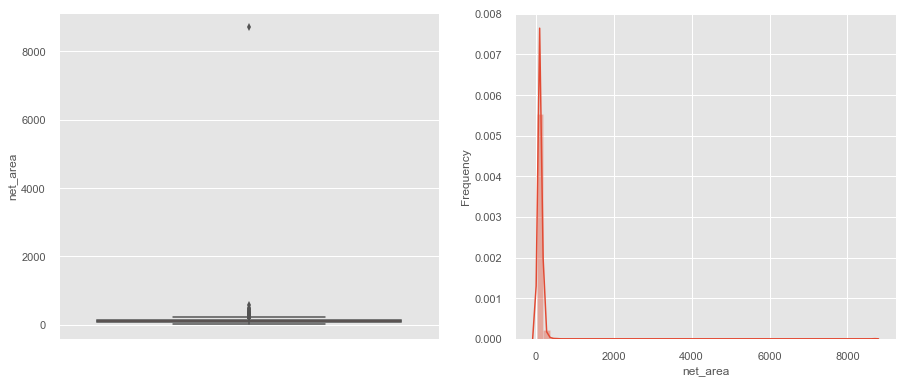

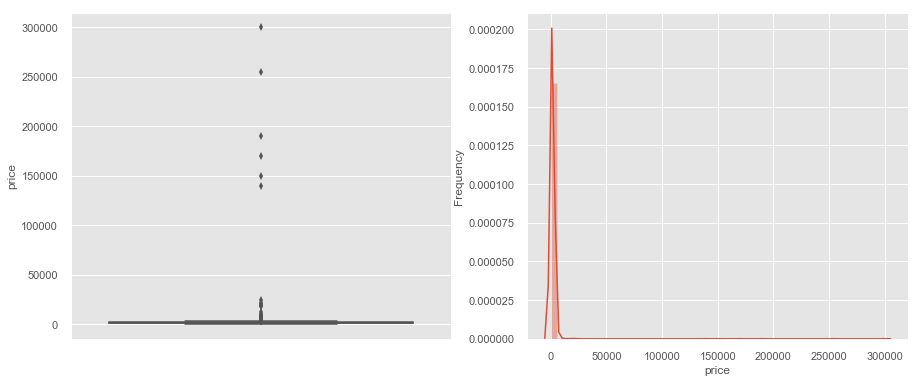

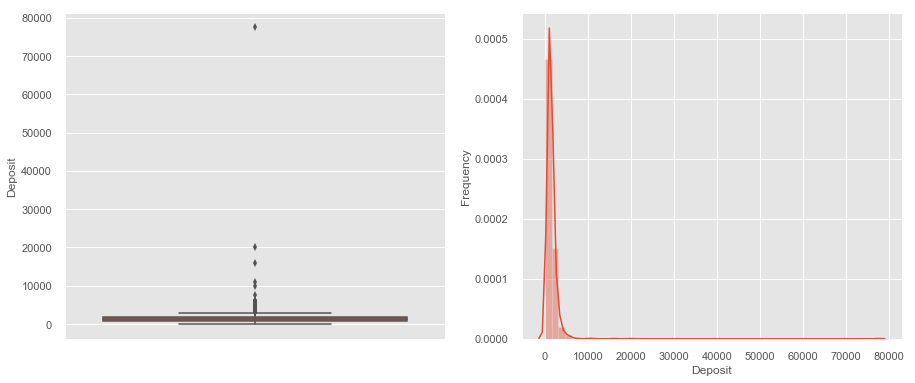

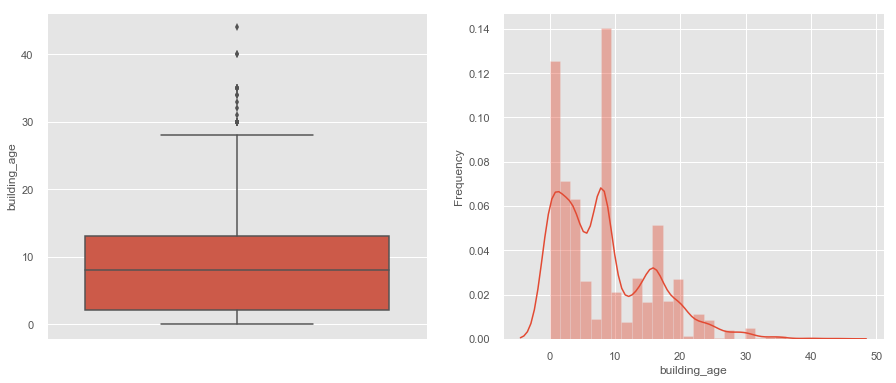

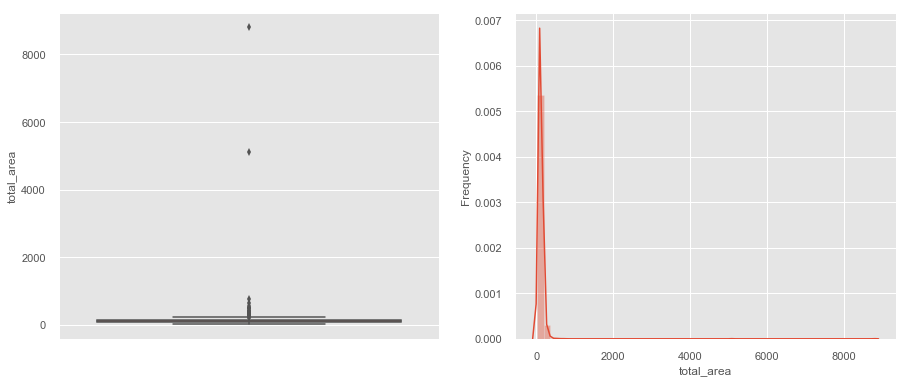

In [310]:
for var in continuous:
    if var not in ['id', 'ad_date']:

        plt.figure(figsize=(15,6))
        plt.subplot(1, 2, 1)
        fig = sns.boxplot(y=data[var])
        fig.set_title('')
        fig.set_ylabel(var)

        plt.subplot(1, 2, 2)
        fig = sns.distplot(data[var].dropna())
        fig.set_ylabel('Frequency')
        fig.set_xlabel(var)

        plt.show()

Because of outliers, distrubition of target variable ("price") is skewed,
it can be interpreted that some houses are for sale, but uncorrectly listed on houses for rent section.
That is why there are houses, which's price are about 300.000 TL. And also there are some incorrect values in "total_area" and "net_area" column.  
This outliers will be removed below.

##### Removing Outliers from data.

In [311]:
def detect_outliers(df, var):
    """
    Detect the upper boundary of particular column.
    If values are higher than this boundary, those values can be considered as outliers.
    """
    q1, q3 = np.percentile(df[var], [25,75])
    iqr = q3 - q1
    lower_bound = q1 -(1.5 * iqr) 
    upper_bound = q3 +(1.5 * iqr)
    print(var, upper_bound)

In [312]:
detect_outliers(final_data.dropna(), 'price')

price 2725.0


In [313]:
cleaned_price = data[(data.price >= 500) & (data.price <= 2800)]

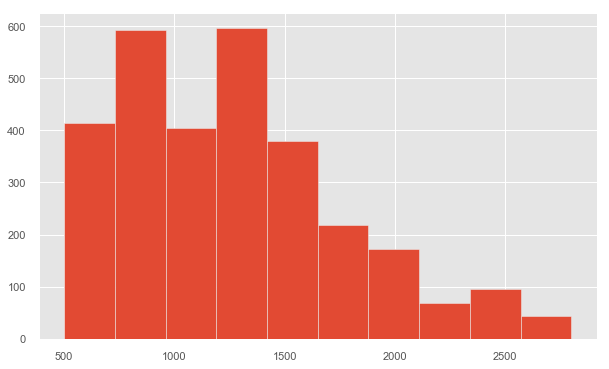

In [314]:
cleaned_price['price'].hist(bins = 10)

In [315]:
cleaned_price_and_net_area = cleaned_price[cleaned_price.net_area <= 285]

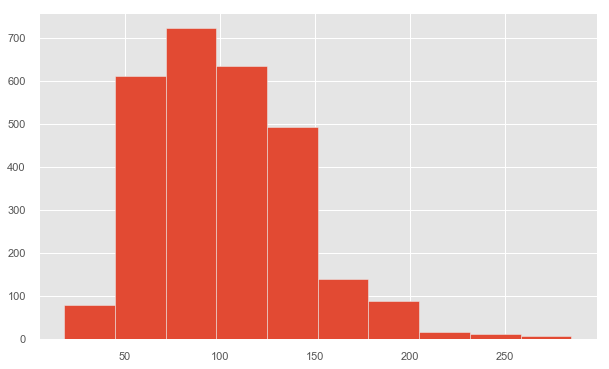

In [316]:
cleaned_price_and_net_area.net_area.hist()

In [317]:
test_for_Deposit = cleaned_price_and_net_area[cleaned_price_and_net_area['Deposit'] <= 2800]

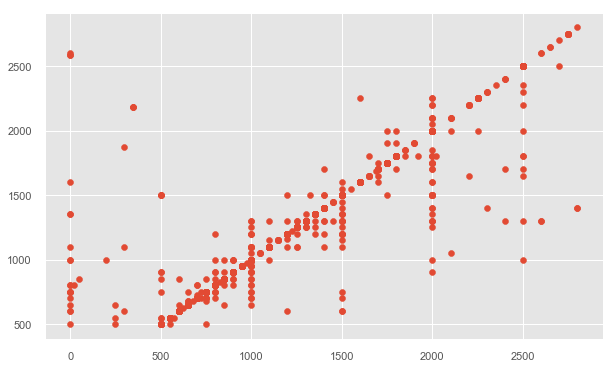

In [318]:
plt.scatter(test_for_Deposit.Deposit, test_for_Deposit.price)

"Deposit" feature simply reflects the actual rental price. if Deposit column seen, Rental price can be esaily estimated.
So "Deposit" is not a good feature for supervized learning problem. I will drop it.

In [319]:
cleaned_price_and_net_area.drop('Deposit',1,inplace=True)

###### Logistic Regression for predicitng missing values in "furnitured" column

"furnitured" column has %30 missing values. It can be useful for this model if those values are predictied by classification algorithm.

In [320]:
dframe = cleaned_price_and_net_area

In [321]:
dframe.isnull().sum()

furnitured          863
residential site      0
heating_system       35
number_floors        78
Title                 0
number_rooms        495
net_area              0
price                 0
ad_date               0
district              0
number_bathroom     497
county                0
id                    0
building_age        495
floor_wthn_bldng    593
total_area            0
is_private            0
is_new                0
has_view              0
is_lux                0
in_Konyaaltı          0
in_Muratpasa          0
in_Kepez              0
in_Alanya             0
in_Manavgat           0
in_Aksu               0
in_Dosemealtı         0
in_Kemer              0
in_Serik              0
in_Kumluca            0
in_Finike             0
in_Korkuteli          0
in_Kas                0
in_Gazipasa           0
in_Akseki             0
in_Elmalı             0
F1                    0
F2                    0
F3                    0
F4                    0
F5                    0
F6              

In [322]:
dframe.number_rooms.fillna(dframe.number_rooms.median(), inplace=True)

In [323]:
dframe.building_age.fillna(dframe.building_age.median(), inplace=True)

In [324]:
dframe = dframe[['F4', 'in_Konyaaltı', 'F3', 'is_lux', 'price', 
                 'furnitured', 'net_area', 'number_rooms', 'in_Alanya',
                 'in_Kepez','F7','total_area', 'building_age','is_new']]

In [325]:
dframe.isnull().sum()

F4                0
in_Konyaaltı      0
F3                0
is_lux            0
price             0
furnitured      863
net_area          0
number_rooms      0
in_Alanya         0
in_Kepez          0
F7                0
total_area        0
building_age      0
is_new            0
dtype: int64

In [326]:
df_for_ml = dframe.dropna()

In [327]:
X = df_for_ml[['price', 'F4','in_Konyaaltı', 'F3', 'is_lux', 
               'in_Alanya','number_rooms', 'net_area','in_Kepez',
               'total_area','building_age','is_new']]

y = df_for_ml['furnitured']

In [328]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [329]:
logmodel = LogisticRegression(solver='liblinear', penalty='l1')

In [330]:
logmodel.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [331]:
logmodel.score(X_train, y_train) # Train accuracy 

0.818041634541249

In [332]:
logmodel.score(X_test,y_test) # Test accuracy

0.7856025039123631

In [333]:
predictions = logmodel.predict(X_test)

In [334]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         0.0       0.81      0.78      0.79       339
         1.0       0.76      0.80      0.78       300

   micro avg       0.79      0.79      0.79       639
   macro avg       0.79      0.79      0.79       639
weighted avg       0.79      0.79      0.79       639



In [335]:
pd.crosstab(y_test, predictions, rownames = ['True'], colnames = ['Predicted'], margins = True)

Predicted,0.0,1.0,All
True,,,
0.0,263,76,339
1.0,61,239,300
All,324,315,639


In [336]:
# Part of dataset where values of 'furnitured' column are NaN
nans = cleaned_price_and_net_area[cleaned_price_and_net_area['furnitured'].isnull()]
# Part of dataset where values of 'furnitured' column are not NaN
notnans = cleaned_price_and_net_area[~cleaned_price_and_net_area['furnitured'].isnull()]

In [337]:
# Features for logistic regression model.
values_to_predict = nans[['price', 'F4','in_Konyaaltı', 'F3', 'is_lux', 
                          'in_Alanya','number_rooms', 'net_area','in_Kepez',
                          'total_area','building_age','is_new']].values

In [338]:
#Predicting NaN values.
nans['furnitured'] = logmodel.predict(values_to_predict)

In [339]:
df = pd.concat([nans, notnans],ignore_index=True)

In [340]:
df.dropna(inplace=True)

In order to implement Machine Learning model to this data set. We have to choose only columns that consist of numerical values. 

In [341]:
cols_to_keep = [i for i in df.columns if i not in ['id','number_floors','is_new','in_Dosemealtı', 'in_Akseki', 'ad_date']]

In [342]:
df = df[cols_to_keep]

In [343]:
def district_parser(district_name):
    """
    Returns mean rental price by district and number of rows for that district.
    """
    mean_price = df.groupby('district')['price'].mean().sort_values(ascending=False).loc[district_name]
    rows = df[df['district'] == district_name].shape[0]
    return mean_price, rows

# district_names = []
# for i in df['district'].unique():
#     mean_price, number_rows = district_parser(i)
#     # If this district has less than 10 data points ignore it.
#     if number_rows < 10:
#         continue
#     else:
#         print('mean price is {} and number of rows are {} for {}'.format(mean_price, number_rows, i))
#         district_names.append(i)

# for deploying ML model to web
district_names = []
for i in df['district'].unique():
    district_names.append(i)

In [344]:
def stratify_districts(df, feature_names):
    """
    Stratifies the district column. 
    """
    for district in feature_names:
        df['in_'+str(district)] = df["district"].apply(lambda x: 1 if x == district else 0)

In [345]:
stratify_districts(df, district_names)

In [346]:
def near_uni(in_Kultur, in_Ahatlı, in_Meltem):
    """
    if apartment is located in Kultur, Ahatli or Meltem, this apartment can be considered as near university.
    if so, returns 1. Otherwise returns 0
    """
    if in_Kultur == 1 or in_Ahatlı == 1 or in_Meltem == 1:
        return 1
    else:
        return 0

In [347]:
df['near_uni'] = list(map(near_uni, df['in_Kultur'], df['in_Ahatlı'], df['in_Meltem']))

In order to implement Machine Learning to this dataset, I need to drop all categorical features and keep only numerical ones. 

In [348]:
# Dropping categorical features  
df.drop(['district', 'county', 'Title'], 1, inplace=True)

Now data only contains numerical features.

In [349]:
def myPCA(df, clusters=None):
    # Normalize data
    df = df.dropna()
    df_norm = (df - df.mean()) / df.std()
    # PCA
    pca = PCA(n_components=2)
    pca_res = pca.fit_transform(df_norm.values)
    # Ebouli
    ebouli = pd.Series(pca.explained_variance_ratio_)
    plt.show()
    # Circle of correlations
    # http://stackoverflow.com/a/22996786/1565438
    coef = np.transpose(pca.components_)
    cols = ['PC-'+str(x) for x in range(len(ebouli))]
    pc_infos = pd.DataFrame(coef, columns=cols, index=df_norm.columns)
    circleOfCorrelations(pc_infos, ebouli)
    plt.show()
    # Plot PCA
    return pc_infos, ebouli

In [350]:
df = df.dropna()
df_norm = (df - df.mean()) / df.std()
# PCA
pca = PCA(n_components=0.99,svd_solver='full')
pca_res = pca.fit_transform(df_norm.values)

In [351]:
pca.n_components_

193

In [352]:
def circleOfCorrelations(pc_infos, ebouli):
    plt.figure(figsize=(20,15))
    plt.Circle((0,0),radius=10, color='g', fill=False)
    circle1=plt.Circle((0,0),radius=1, color='g', fill=False)
    fig = plt.gcf()
    fig.gca().add_artist(circle1)
    for idx in range(len(pc_infos["PC-0"])):
        x = pc_infos["PC-0"][idx]
        y = pc_infos["PC-1"][idx]
        plt.plot([0.0,x],[0.0,y],'k-')
        plt.plot(x, y, 'rx')
        plt.annotate(pc_infos.index[idx], xy=(x,y))
    plt.xlabel("PC-0 (%s%%)" % str(ebouli[0])[:4].lstrip("0."))
    plt.ylabel("PC-1 (%s%%)" % str(ebouli[1])[:4].lstrip("0."))
    plt.xlim((-1,1))
    plt.ylim((-1,1))
    plt.title("Circle of Correlations")
    

<Figure size 1080x720 with 0 Axes>

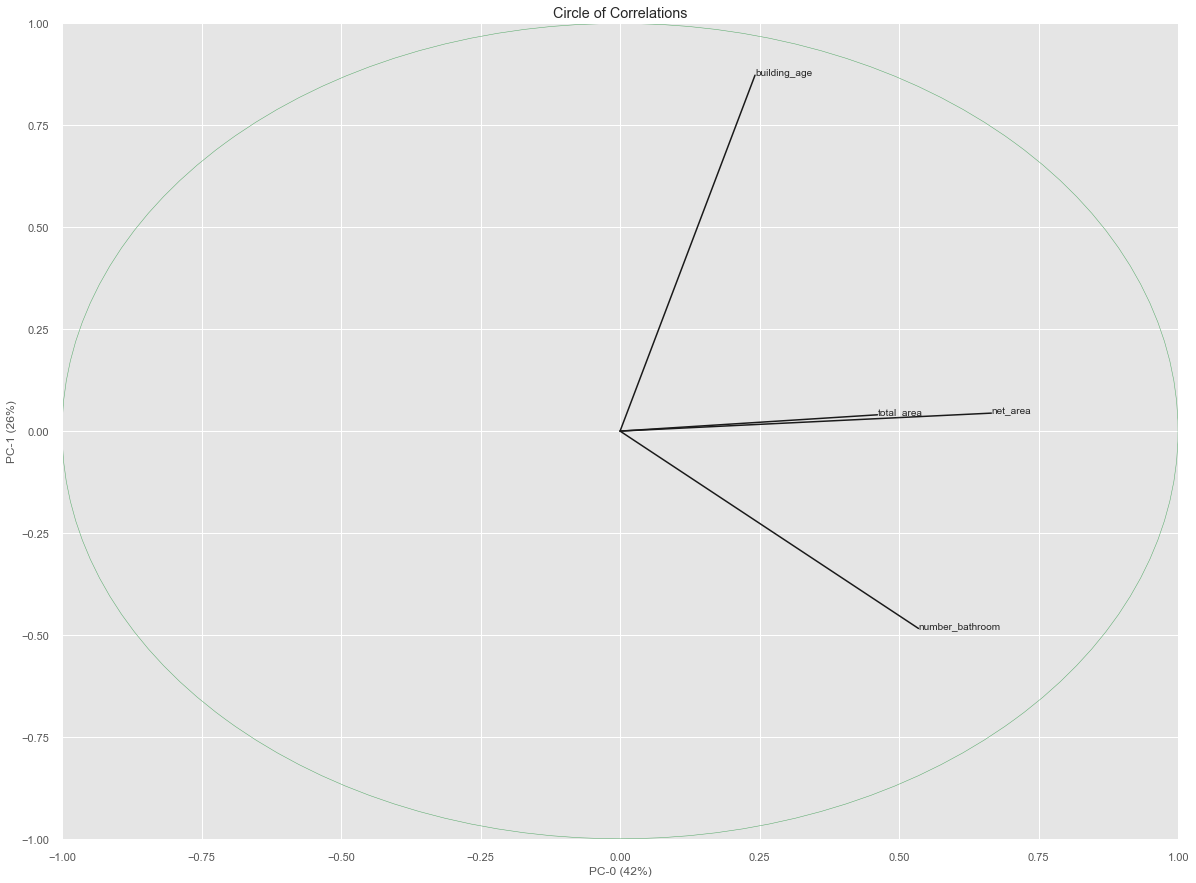

In [353]:
columns = ['net_area','number_bathroom', 'total_area', 'building_age']
plt.figure(figsize=(15,10))
#columns = list(X_train.columns)
#columns.append('price')
dfPca = df[columns]
myPCA(dfPca)
plt.show()

As shown in circle of correlations plot, there is a linear relationship between total_area and net_area. To avoid multicolinearity, I will drop 'total_area' feature.

In [354]:
df.drop('total_area',1, inplace=True)

### Building Machine Learning model

In [355]:
#Splitting the dataSet into train and test sets.
if 'selected_features' not in list(vars()): 
    X_train, X_test, y_train, y_test = train_test_split(df.drop('price',1),
                                                    df['price'], 
                                                    test_size=0.20, random_state=69,shuffle=True)
else:
    X_train, X_test, y_train, y_test = train_test_split(df[selected_features],
                                                    df['price'], 
                                                    test_size=0.20, random_state=69,shuffle=True)
    


If there is no ML model and there is no features that selected by importance score of ML model, above code splits data set into train and test sets by dropping target variabel. But if "selected_features" variable is defined by "feature_selection" function, code splits data set into test and train sets by including selected features.

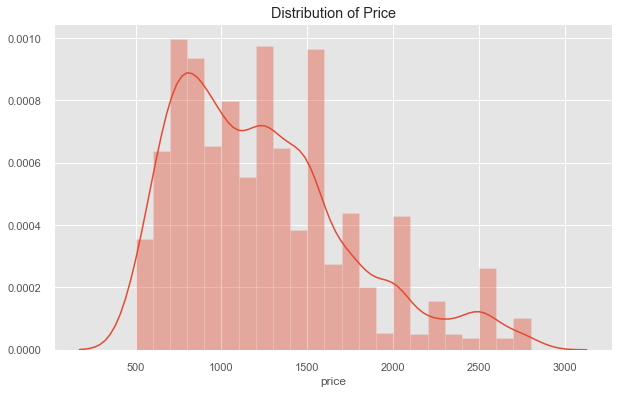

In [356]:
#df['price'].hist()
sns.distplot(df['price'], bins='auto')
plt.title('Distribution of Price')
plt.show()

As seen above, distribution of target variable seems like lognormal. I will test this with normal probability plot method. 

In [357]:
def FitLine(x_borders, intercept, slope):
    """
    Fits a line to the given data.

    x_borders: the min and max values on x axis. This is user defined

    returns: tuple of numpy arrays (sorted xs, fit ys)
    """
    fit_xs = np.sort(x_borders)
    fit_ys = intercept + slope * fit_xs
    return fit_xs, fit_ys

def normal_probability_plot(feature, x_axis_borders, feature_name):
    """
    returns: normal probability plot of choosen variable.
    """
    mean = feature.mean()
    std = feature.std()

    fxs, fys = FitLine(x_axis_borders, mean, std)

    sorted_sample = np.sort(feature)
    n = len(sorted_sample)
    synthetic_sample = np.random.normal(size = n)
    sorted_synthetic_sample = np.sort(synthetic_sample)

    plt.plot(fxs, fys)
    plt.plot(sorted_synthetic_sample, sorted_sample)
    plt.xlabel('synthetic sample')
    plt.ylabel('sample of {} variable'.format(feature_name))
    plt.title('Normal Probability Plot of {}'.format(feature_name))
    plt.show()


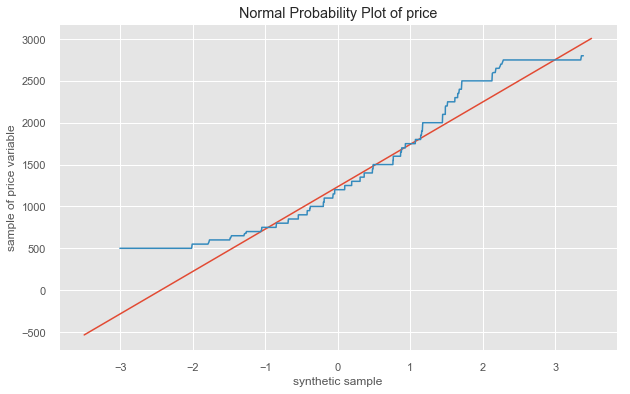

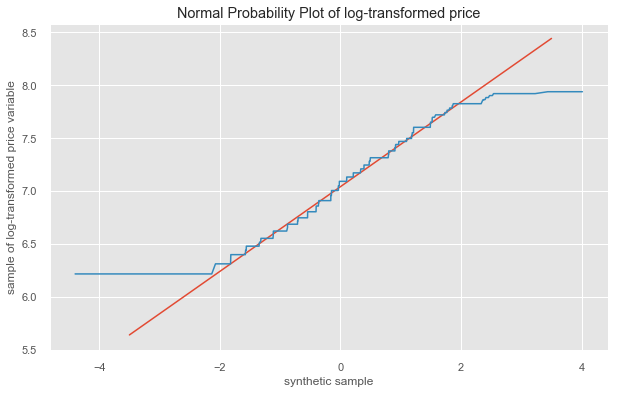

In [358]:
normal_probability_plot(df['price'], [-3.5,3.5], 'price')
transformed_target = np.log(pd.concat([y_train,y_test],ignore_index=True))
normal_probability_plot(transformed_target, [-3.5, 3.5], 'log-transformed price')

If the distribution of the variable is approximately normal, the plot of the sorted values from the sample versus the random values (normal probability plot) is like a straight line.
As shown above, distribution of log-transformed target variable is more like a normal distribution. I will implement log-normal transformation to the target variable.

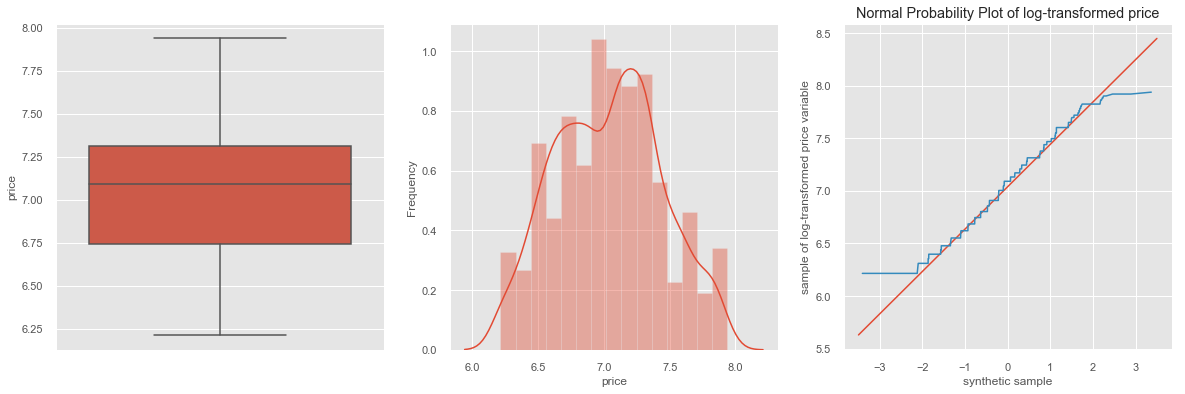

In [359]:
var = 'price'
y_train = np.log(y_train) 
y_test = np.log(y_test) 

plt.figure(figsize=(20,6))
plt.subplot(1, 3, 1)
fig = sns.boxplot(y=y_train)
fig.set_title('')
fig.set_ylabel(var)

plt.subplot(1, 3, 2)
fig = sns.distplot(y_train, bins=15)#.hist(bins=20)
fig.set_ylabel('Frequency')
fig.set_xlabel(var)

plt.subplot(1,3,3)
fig = normal_probability_plot(y_train, [-3.5, 3.5], 'log-transformed price')
plt.show()

In [360]:
# from math import sqrt

# xgb_model = xgb.XGBRegressor(learning_rate=0.09, n_estimators=720, objective='reg:linear', gamma=0.1, reg_alpha=0.6, 
#                             subsample=0.3, max_depth=6, colsample_bytree=0.5, min_child_weight=1.4,)

# eval_set = [(X_test, y_test)]
# xgb_model.fit(X_train, y_train, eval_set=eval_set, verbose=True)

In [361]:
# pred_test = xgb_model.predict(X_test)
# pred_train = xgb_model.predict(X_train)
# np.sqrt(mean_squared_log_error(y_test, pred_test)), np.sqrt(mean_squared_log_error(y_train, pred_train))

##### LightGBM

In [362]:
# lgb_train = lgb.Dataset(X_train, y_train)
# lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

In [363]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =9, min_sum_hessian_in_leaf = 11)

In [364]:
model_lgb.fit(X_train, y_train)

LGBMRegressor(bagging_fraction=0.8, bagging_freq=5, bagging_seed=9,
       boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       feature_fraction=0.2319, feature_fraction_seed=9,
       importance_type='split', learning_rate=0.05, max_bin=55,
       max_depth=-1, min_child_samples=20, min_child_weight=0.001,
       min_data_in_leaf=9, min_split_gain=0.0, min_sum_hessian_in_leaf=11,
       n_estimators=720, n_jobs=-1, num_leaves=5, objective='regression',
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

### Diagnosing Model 

In [366]:
from math import sqrt
pred = model_lgb.predict(X_train)
print('lightGBM train rmsle: {}\n'.format(np.sqrt(mean_squared_log_error(y_train, pred))))

pred = model_lgb.predict(X_test)
print('lightGBM test rmsle: {}'.format(np.sqrt(mean_squared_log_error(y_test, pred))))

lightGBM train rmsle: 0.02537714794166167

lightGBM test rmsle: 0.025183872576344107


In [367]:
class DiagnoseModel:
    """
    Parametres
    -----------        
    model: LightGBM model.
    
    val_x: Pandas Dataframe
        independent variables for validation data.
    
    val_y: Pandas Dataframe
        dependent variable for validation data.
    
    train_x: Pandas Dataframe
        independent variables for train data.
    
    train_y: Pandas Dataframe
        dependent variable for train data.

    eval_metric: string. 'rmsle', 'rmse' or 'mse'
        evaluation metric for model. 
    -----------
    """
    def __init__(self, model, val_x, val_y, train_x, train_y, eval_metric):
        self.model = model
        self.eval_metric = eval_metric
        self.val_x, self.val_y = val_x, val_y
        self.train_x, self.train_y = train_x, train_y
    
    @property
    def info(self):
        # predictions using train and validation set.
        pred_train = self.model.predict(self.train_x)
        pred_val = self.model.predict(self.val_x)

        residuals = self.val_y - pred_val
        print("Residuals Informations")
        print(residuals.describe())

        # Explained variance score: 1 is perfect prediction
        print('Variance score: %.2f' % r2_score(self.val_y, pred_val))

        if self.eval_metric == 'rmsle':
            print('train {} is {}'.format(self.eval_metric, np.sqrt(mean_squared_log_error(self.train_y, pred_train))))
            print('test {} is {}'.format(self.eval_metric, np.sqrt(mean_squared_log_error(self.val_y, pred_val))))

        elif self.eval_metric == 'rmse':
            print('train {} is {}'.format(self.eval_metric, sqrt(mean_squared_error(self.train_y, pred_train))))
            print('test {} is {}'.format(self.eval_metric, sqrt(mean_squared_error(self.val_y, pred_val))))

        elif self.eval_metric == 'mse':
            print('train {} is {}'.format(self.eval_metric, mean_squared_error(self.train_y, pred_train)))
            print('test {} is{}'.format(self.eval_metric, mean_squared_error(self.val_y, pred_val)))

        else:
            print('metric is not defined!')
        return

    def plot_model(self):
        # predictions using train and validation set.
        pred_train = self.model.predict(self.train_x)
        pred_val = self.model.predict(self.val_x)

        # Plot outputs
        obs = [cpt for cpt in range(1,len(self.val_y)+1)]
        rentSeriesTest = pd.Series(self.val_y.tolist())
        obsSeries = pd.Series(obs)
        fig, ax = plt.subplots(figsize=(12, 8))
        sns.regplot(x=obsSeries,y=pred_val,truncate =True,color="red",marker="*",label="Predicted Values")
        ax.scatter(obs, rentSeriesTest, color='blue', linewidth=2,label="Real Values")
        ax.set_xticks(obs) #Showing all range of number of rooms on the x axis
        ax.set_yticks(pred_val, minor=True) #Showing all range of number of rooms on the x axis
        #line1.set_dashes(dashes)
        ax.set_ylabel('Rent amount',fontsize=7)
        ax.set_xlabel('Test Observation number',fontsize=7)
        ax.set_title('Prediction and real Value in test set',fontsize=8)
        plt.tight_layout()
        ax.legend(loc="best")
        plt.show()
        return None

    def plot_resudials(self):
        visualizer = ResidualsPlot(self.model)
        visualizer.fit(self.train_x, self.train_y)  # Fit the training data to the model
        visualizer.score(self.val_x, self.val_y)  # Evaluate the model on the test data
        visualizer.poof()
        return None

    def plot_learning_curves(self, data, test_size_range, log_transform=True):
        """
        Parametres
        -----------
        data: Pandas Data Frame
            data for model.
        test_size_range: list object
            range of test size. e.g. [0.15, 0.30]
        log_transform: boolean, default True
            if True, target variable will be log-transformed.
        -----------
        """
        #This is the same GBM model (it has same parametres as previous model) as previous.
        #Because of calling model.fit() in this class method with train data that has default features,
        #I defined this model with different variable name in order to distinguish this from first model.
        model_2 = lgb.LGBMRegressor(**self.model.get_params())
        test_errs = list() # list of test errors
        train_errs = list() # List of train errors
        train_size = list() # list of training data sizes

        start = int(test_size_range[-1] * 100)
        stop = int(test_size_range[0] * 100)
        for i in range(start, stop, -1):
            #I will set test size as i / 100 for each value of i.
            # Test size will range 0.46 to 0.11.
            # then I am going to decrease test size by 0.01 in each iteration.

            #splitting dataset into train and test sets.
            train_X, test_X, train_y, test_y = train_test_split(data.drop('price',1),
                                                                data['price'],
                                                                test_size=(i/100), # settting test size i / 100.
                                                                random_state=69,
                                                                shuffle=True)
            if log_transform:
                #log-transforming target variable.
                train_y = np.log(train_y)
                test_y = np.log(test_y)

            train_size.append(train_X.shape[0])

            # Fitting model to different training size in each iteration.
            model_2.fit(train_X, train_y)

            pred_train = model_2.predict(train_X) # Predicting train data
            pred_test = model_2.predict(test_X) # Predicting test data

            if self.eval_metric == 'rmsle':
                assert log_transform, "Data is not log-transformed. Use 'rmse' instead."
                train_error = np.sqrt(mean_squared_log_error(train_y, pred_train)) # Train RMSLE
                train_errs.append(train_error)
                test_error = np.sqrt(mean_squared_log_error(test_y, pred_test)) # Test RMSLE
                test_errs.append(test_error)

            elif self.eval_metric == 'rmse':
                assert not log_transform, "Data is log-transformed. Use 'rmse or mse' instead."
                train_error = sqrt(mean_squared_error(train_y, pred_train)) # Train RMSE
                train_errs.append(train_error)
                test_error = sqrt(mean_squared_error(test_y, pred_test)) # Test RMSE
                test_errs.append(test_error)

            elif self.eval_metric == 'mse':
                assert not log_transform, "Data is log-transformed. Use 'rmse' or 'mse' instead."
                train_error = mean_squared_error(train_y, pred_train) # Train MSE
                train_errs.append(train_error)
                test_error = mean_squared_error(test_y, pred_test)  # Test MSE
                test_errs.append(test_error)

            else:
                print('metric is not defined')

        sns.set(rc = {'figure.figsize':(10,6)})
        plt.plot(train_size, test_errs, label = 'Test Error')
        plt.plot(train_size, train_errs,label = 'Train Error')
        plt.xlabel('Train size')
        plt.ylabel('Train and Test Errors')
        plt.legend()
        plt.show()


In [368]:
d_model = DiagnoseModel(model_lgb, X_test, y_test, X_train, y_train, 'rmsle')

In [369]:
d_model.info

Residuals Informations
count    434.000000
mean      -0.020879
std        0.202228
min       -0.632202
25%       -0.149102
50%       -0.021070
75%        0.096185
max        0.769402
Name: price, dtype: float64
Variance score: 0.73
train rmsle is 0.02537714794166167
test rmsle is 0.025183872576344107


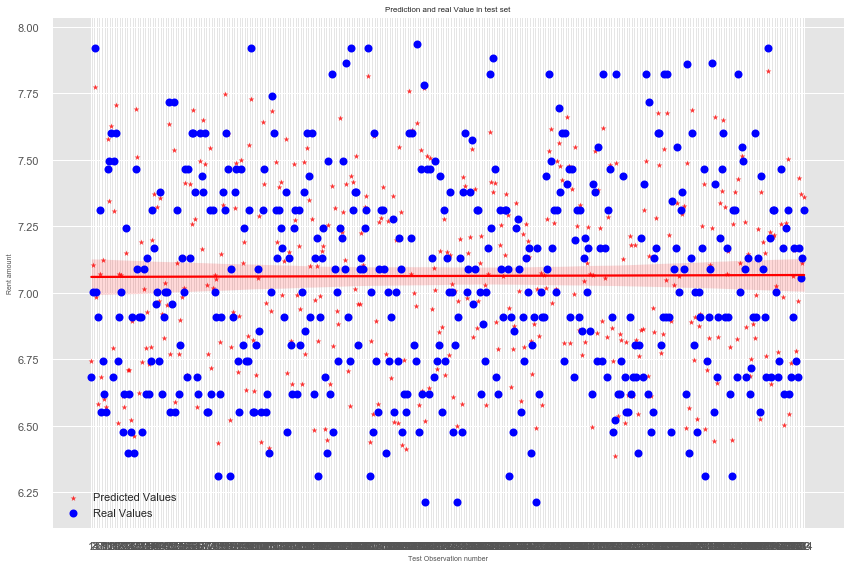

In [370]:
d_model.plot_model()

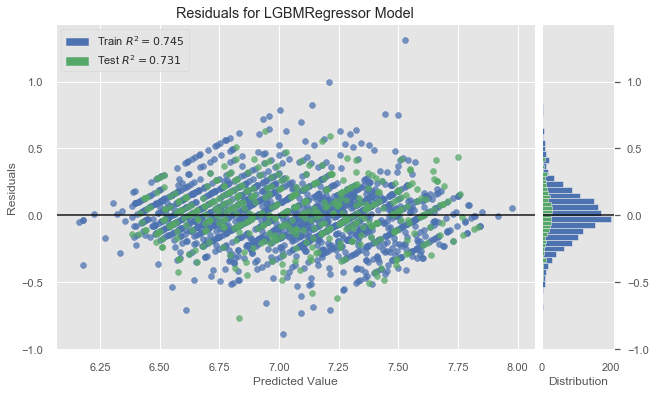

In [371]:
d_model.plot_resudials()

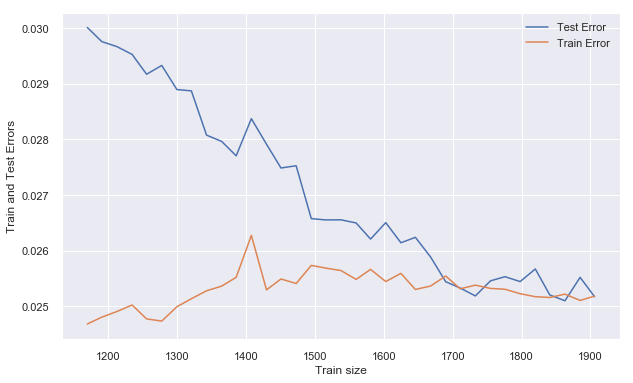

In [373]:
d_model.plot_learning_curves(df, [0.11, 0.46])

Learning Curves is a plot that compares the performance of a model on train and test data over a varying number of training instances. We can get an idea of how well the model can generalize to new data with learning curves for training and test sets. If there is a gap between test error and train error and the gap expands while training data size increases, this indicates overfitting. if train and test errors are high and train error ends up so close to test error at high error level, as well as the test error flattens out while train size increases, it indicates underfitting.

In [152]:
# import pickle
# filename = './Application/model_lgb.pkl'
# pickle.dump(model_lgb, open(filename, 'wb'))

In order to deploy this ML model as a web application, I need to include all district and county features. Because if I choose only selected features to use in model, some of district and county features will be gone. And there is no value if user can't select intented county and district while using my application. So I will pickle "model_lgb" before feature selection process.

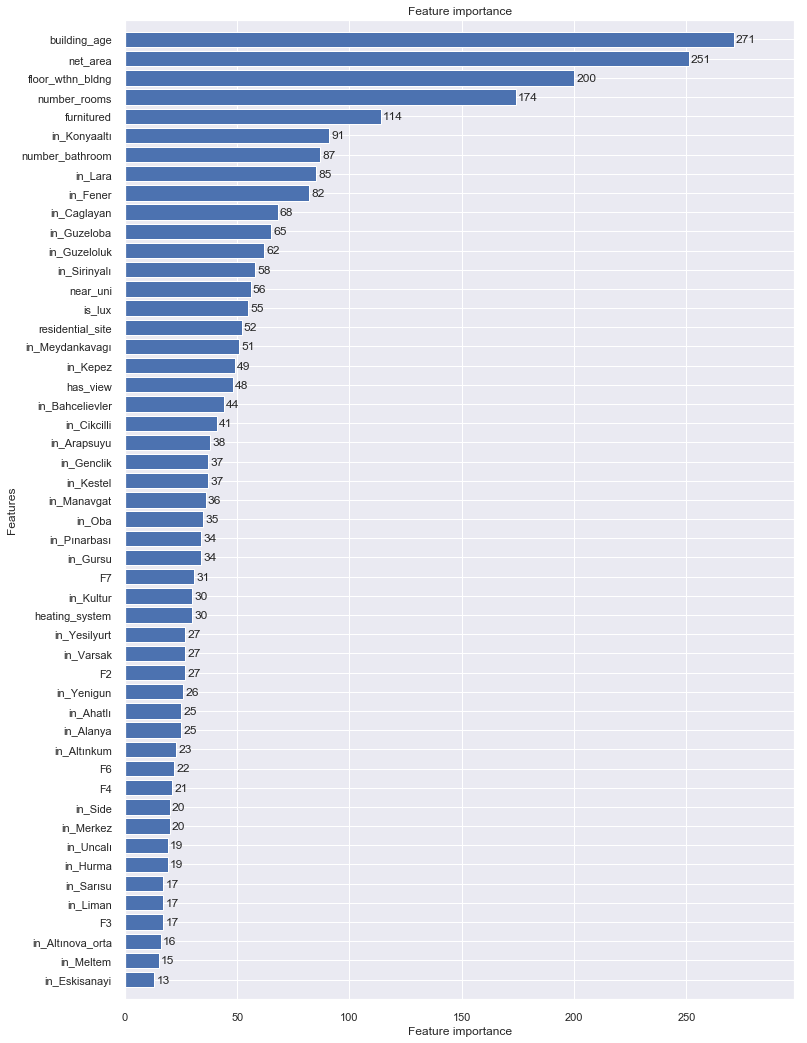

In [158]:
fig, ax = plt.subplots(figsize=(12,18))
lgb.plot_importance(model_lgb, max_num_features=50, height=0.8, ax=ax)
plt.show()

In [153]:
def feature_selection(feature_importances, train_feats, threshold):
    """
    Parameters.
    -----------
    feature_importances: importance score of each features that used in model.
    train_feats: columns in X_train
    threshold: threshold value to eliminate features that have lower score than this value.
    -----------
    Returns: Features that have more score than threshold value.
    """
    scores = feature_importances
    df = pd.DataFrame({'cols':np.array(train_feats), 'vals':scores})
    df.sort_values(by='vals', inplace=True)
    return df[df['vals'] > threshold].cols.values

To impelement LightGBM model with selected features, run all the cells above once again.
Dropping features with importance score lower than 20 had impact to decrease overfitting. It can be observed by looking at RMSLE of train and test data sets.

In [154]:
selected_features = feature_selection(model_lgb.feature_importances_, X_train.columns, 20)
selected_features

array(['F4', 'F6', 'in_Altınkum', 'in_Ahatlı', 'in_Alanya', 'in_Yenigun',
       'F2', 'in_Yesilyurt', 'in_Varsak', 'in_Kultur', 'heating_system',
       'F7', 'in_Pınarbası', 'in_Gursu', 'in_Oba', 'in_Manavgat',
       'in_Kestel', 'in_Genclik', 'in_Arapsuyu', 'in_Cikcilli',
       'in_Bahcelievler', 'has_view', 'in_Kepez', 'in_Meydankavagı',
       'residential site', 'is_lux', 'near_uni', 'in_Sirinyalı',
       'in_Guzeloluk', 'in_Guzeloba', 'in_Caglayan', 'in_Fener',
       'in_Lara', 'number_bathroom', 'in_Konyaaltı', 'furnitured',
       'number_rooms', 'floor_wthn_bldng', 'net_area', 'building_age'],
      dtype=object)

### Data Visualization

#### For interactive Data Visualization: https://public.tableau.com/profile/badal8117#!/vizhome/Antalyahomepricebook1/RentalPricesinAntalya

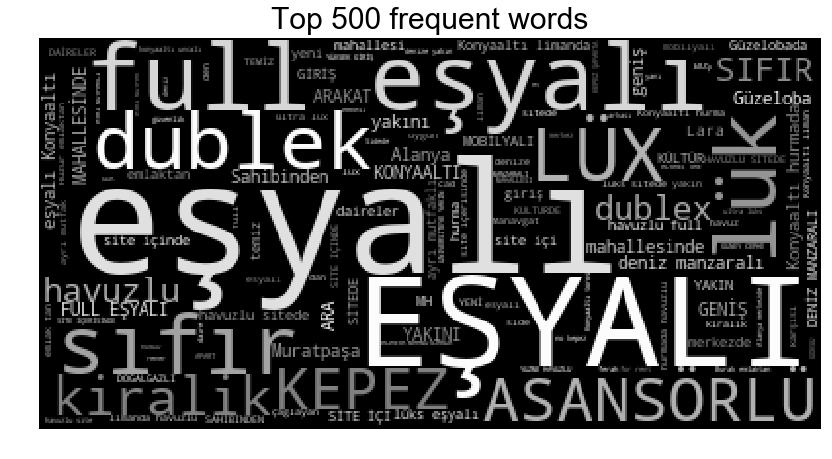

In [155]:
def grey_color(word, font_size, position, orientation, random_state=None, **kwargs):
    return 'hsl(0, 0%%, %d%%)' % random.randint(50, 100)

def generateWordCloud(dframe):
    limit = 1000
    infosize = 12
    descriptionText = " ".join(dframe['Title'].astype(str))
    title = 'Top 500 frequent words'
    fontcolor='black'
    bgcolor = '#000000'
    stopword = stopwords.words('turkish') + ['Antalya', 'KİRALIK', 'DAİRE', 'daire', 
                                             'katta', 'kat', 'kiralık', 'm2', 'da', 'mah', 'tl']
    wordcloud = WordCloud(
        max_words=500,
        stopwords=stopword,
        background_color=bgcolor,
    ).generate(descriptionText)
    
    fig = plt.figure()
    fig.set_figwidth(14)
    fig.set_figheight(18)
    plt.imshow(wordcloud.recolor(color_func=grey_color, random_state=3))
    plt.title(title, color=fontcolor, size=30, y=1.01)
    plt.axis('off')
    plt.show()

generateWordCloud(final_data)

In [170]:
def partial_dependence_plot(model, data, model_feats, feature):
    """
    Parametres
    -----------
    model_feats: list
        list of features, that's been used in ML model.
    feature: string
        intented feature for PDP.
    -----------
    Returns: Partial Dependence Plot for choosen feature.
    """
    p = pdp.pdp_isolate(model=model, dataset=data,
                    model_features=model_feats,
                    feature=feature)
    ig, axes = pdp.pdp_plot(p, feature,plot_lines=True, frac_to_plot=100, cluster=False, figsize=(6,6))

Partial pependence plot is plotting the independent variable e.g. 'net_area' vs the model outcome e.g. 'price', after considering the average effect of other independent variables in the model. Also notice that partial dependence plot is not plotting relationship between independent variables and target variable. 
Partial dependence plot is particular useful when we want to figure out the “marginal effect” of one (or several) particular variable(s) on the predict outcome when using ensemble machine learning methods (like boosting or bagging). Because of its complex nature, we cannot identify the marginal effect by simply reviewing the equation.

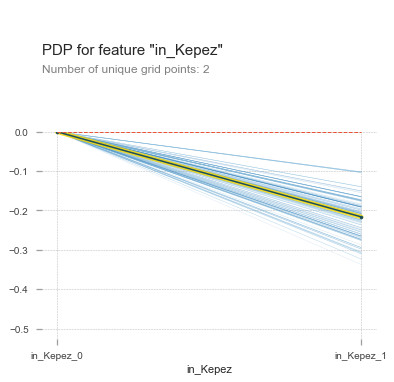

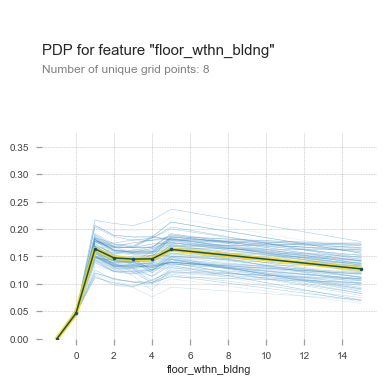

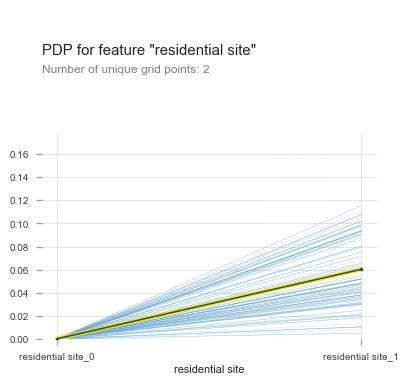

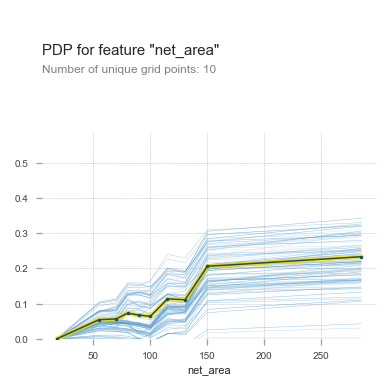

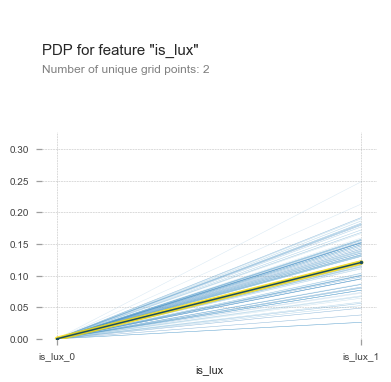

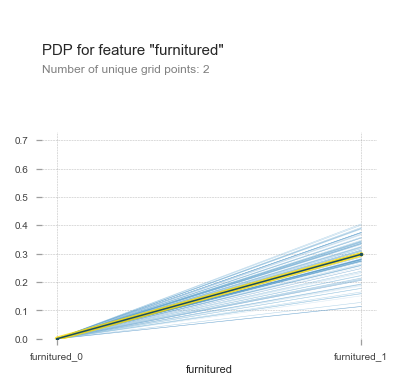

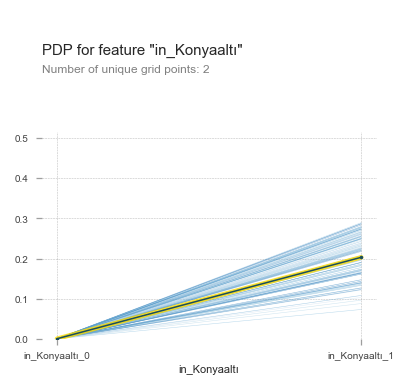

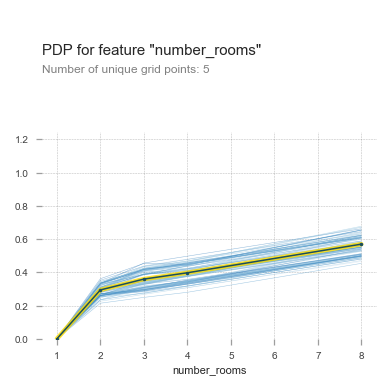

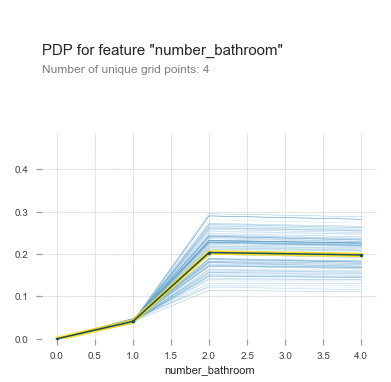

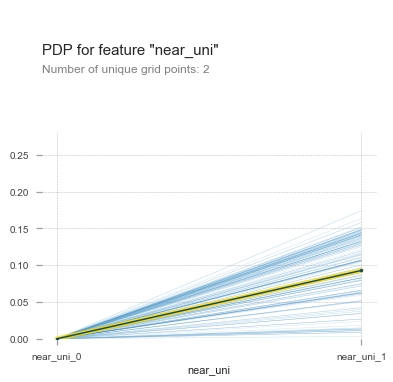

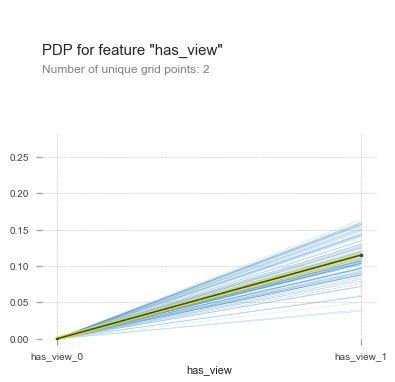

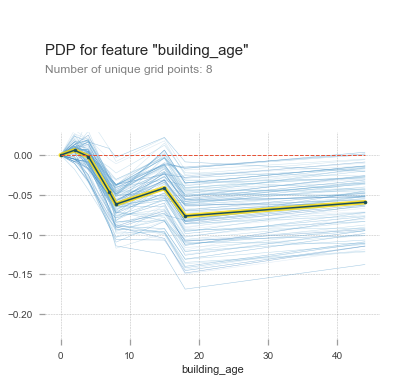

In [171]:
features_to_plot = ['in_Kepez', 'floor_wthn_bldng', 'residential site',
                    'net_area', 'is_lux', 'furnitured','in_Konyaaltı',
                    'number_rooms', 'number_bathroom', 'near_uni','has_view', 'building_age']

for i in features_to_plot:
    partial_dependence_plot(model_lgb, X_train.join(y_train), X_train.columns, i)

## The End